In [192]:
import gizmo_analysis as gizmo
import halo_analysis as halo
import matplotlib.pyplot as plt
import numpy as np
import utilities as ut
from astropy.io import ascii
from gc_utils import get_halo_tree, main_prog_halt  # noqa: F401
from scipy.optimize import minimize, minimize_scalar

In [193]:
sim = "m12i"
snapshot = 600

sim_dir = "../../../simulations/"
# sim_dir = "../../simulations/"
data_dir = "data/"
sim_codes = data_dir + "external/simulation_codes.json"

fire_dir = sim_dir + sim + "/" + sim + "_res7100/"

In [194]:
pub_snapshot_fil = "/Users/z5114326/Documents/GitHub/gc_kinematics/data/external/snapshot_times_public.txt"
with open(pub_snapshot_fil) as f:
    content = f.readlines()
    content = content[13:]
snap_pub = ascii.read(content)["index"]
tim_pub = ascii.read(content)["time[Gyr]"]
lbt_pub = ascii.read(content)["lookback-time[Gyr]"]

In [195]:
halt = halo.io.IO.read_tree(fire_dir, species="star", assign_hosts_rotation=True)

In [196]:
main_halo_tid = 25236877
tid_main_lst = main_prog_halt(halt, main_halo_tid)

In [197]:
tid_main_pub = []
for tid in tid_main_lst:
    idx = np.where(halt["tid"] == tid)[0][0]
    snap = halt["snapshot"][idx]
    if snap in snap_pub:
        tid_main_pub.append(tid)

In [198]:
snap_dict = {}

for tid in tid_main_pub:
    idx = np.where(halt["tid"] == tid)[0][0]
    snap = halt["snapshot"][idx]
    print(snap)

    part = gizmo.io.Read.read_snapshots("all", "index", snap, fire_dir, assign_hosts_rotation=True)

    rad_lim = halt["star.radius.90"][idx]

    ptype_lst = ["dark", "dark2", "star", "gas"]

    mass_dict = {}
    for ptype in ptype_lst:
        mask = part[ptype].prop("host.distance.principal.total") < rad_lim
        mass = np.sum(part[ptype]["mass"][mask])
        mass_dict[ptype] = mass

    log_temp_lim = 4.5
    tem_mask_cold_gas = np.log10(part["gas"]["temperature"]) < 4.5
    pos_mask_cold_gas = part["gas"].prop("host.distance.principal.total") < rad_lim
    mass_cold_gas = np.sum(part[ptype]["mass"][tem_mask_cold_gas & pos_mask_cold_gas])

    mass_dict["cold_gas"] = mass_cold_gas

    mass_bary = mass_dict["star"] + mass_dict["gas"]
    mass_gas_frac = mass_dict["gas"] / mass_bary
    mass_cold_gas_frac = mass_dict["cold_gas"] / mass_bary

    snap_dict[str(snap)] = {}
    snap_dict[str(snap)]["mass"] = mass_dict
    snap_dict[str(snap)]["gas_frac"] = mass_gas_frac
    snap_dict[str(snap)]["cold_gas_frac"] = mass_cold_gas_frac

/var/folders/nb/byfjq48d6jz8b3g74s3zr7rh0000gp/T/ipykernel_85057/1833920411.py:28: RuntimeWarning: invalid value encountered in scalar divide
  mass_gas_frac = mass_dict["gas"] / mass_bary
/var/folders/nb/byfjq48d6jz8b3g74s3zr7rh0000gp/T/ipykernel_85057/1833920411.py:29: RuntimeWarning: invalid value encountered in scalar divide
  mass_cold_gas_frac = mass_dict["cold_gas"] / mass_bary


In [199]:
snap_lst = []
gas_frac_lst = []

for snap_str in snap_dict.keys():
    snap_lst.append(int(snap_str))

    # gas_frac = snap_dict[snap_str]["cold_gas_frac"]
    gas_frac = snap_dict[snap_str]["gas_frac"]
    gas_frac_lst.append(gas_frac)

In [200]:
snap_plt = []
gas_frac_plt = []

for gas_frac, snap in zip(gas_frac_lst, snap_lst):
    if not np.isnan(gas_frac):
        gas_frac_plt.append(gas_frac)
        snap_plt.append(snap)

tim_lst = []
for snap in snap_plt:
    idx = np.where(snap_pub == snap)[0][0]
    tim = tim_pub[idx]
    tim_lst.append(tim)

Text(0, 0.5, 'Mass Cold Gas / Mass Baryon (within star.radius.90)')

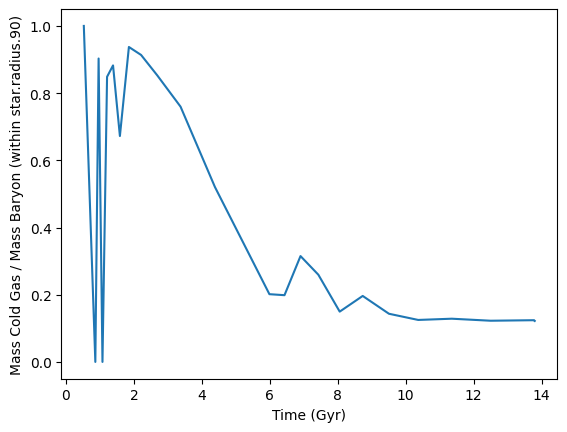

In [201]:
plt.plot(tim_lst, gas_frac_plt)
plt.xlabel("Time (Gyr)")
plt.ylabel("Mass Cold Gas / Mass Baryon (within star.radius.90)")

In [202]:
all_snapshot_fil = "/Users/z5114326/Documents/simulations/m12i/m12i_res7100/snapshot_times.txt"
with open(all_snapshot_fil) as f:
    content = f.readlines()
    content = content[5:]
snap_all = ascii.read(content)["i"]
tim_all = ascii.read(content)["time[Gyr]"]
lbt_all = ascii.read(content)["lookback-time[Gyr]"]

In [203]:
mass_lst = []
tim_lst = []

for tid in tid_main_lst:
    idx = np.where(halt["tid"] == tid)[0][0]
    snap = halt["snapshot"][idx]
    mass_lst.append(halt["mass"][idx])

    idx_all = np.where(snap_all == snap)[0][0]
    tim_lst.append(tim_all[idx_all])

Text(0, 0.5, 'Dark Matter Halo Mass')

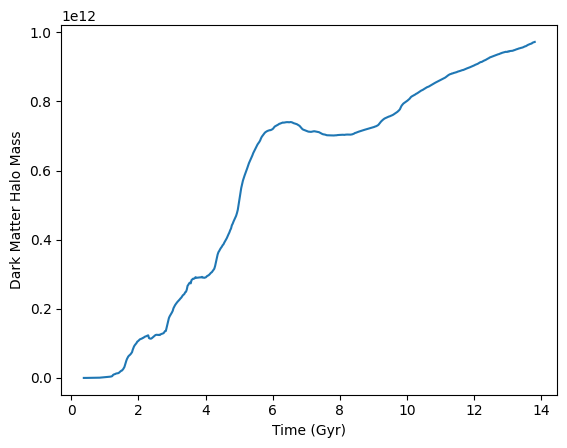

In [204]:
plt.plot(tim_lst, mass_lst)
plt.xlabel("Time (Gyr)")
plt.ylabel("Dark Matter Halo Mass")

In [207]:
growth_rate = np.gradient(mass_lst, tim_lst)

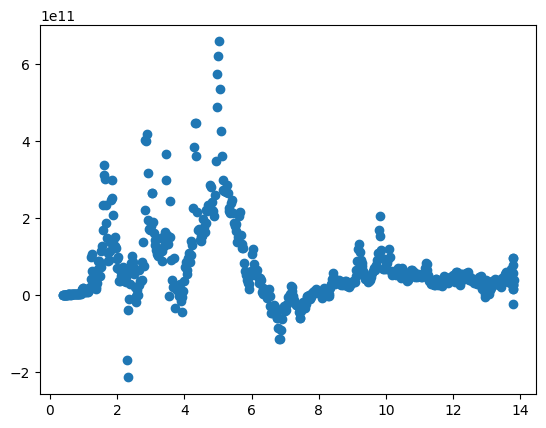

In [208]:
plt.scatter(tim_lst, growth_rate)